In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import sys
sys.path.append(os.path.abspath("./utility_functions"))

import rz_functions as rz
import rz_utility_spring as srz
import scanpy as sc
import scipy as sp
#sc.logging.print_versions()
sc.settings.verbosity = 2

from time import time


python version: 3.6.10


/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
#!{sys.executable} -m pip install fa2

# Load and check filtering from part 1

/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


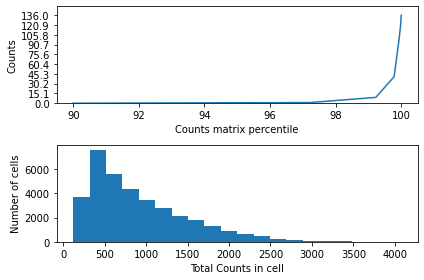

,barcode,group,library_name,marker,max_mt,min_tot,mito_frac,n_counts,n_genes,pool,tissue,treatment
48-pool1,AAACAAACAGAGGATAAGACACCA,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.040964,415.0,348,pool1,Liver,NT
98-pool1,AAACAAACAGAGGATACAATACTT,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.005613,1069.0,581,pool1,Liver,NT
237-pool1,AAACAAACAGAGGATAGGCCCTTA,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.035451,677.0,470,pool1,Liver,NT
246-pool1,AAACAAACAGAGGATAGGGAGGTA,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.018000,500.0,374,pool1,Liver,NT
342-pool1,AAACAAACAGAGGATATGGCTACC,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.035088,627.0,318,pool1,Liver,NT


In [3]:
adata = sc.read_h5ad('backups/tox_marie_filtered_merged_35358x22631_backup_200404_17h27.h5ad')

#all the UMIs from eYFP report IL12B expression
adata[:,['Il12b']].X = adata[:,['Il12b', 'eYFP']].X.sum(1)
adata[:,['eYFP']].X = 0

adata_counts = adata.X.todense()
adata_counts = np.array(adata_counts).reshape(-1)

fig, axes = plt.subplots(2)

axes[0].plot(100 - np.logspace(1,-4,10), np.percentile(adata_counts, 100 - np.logspace(1,-10,10)))
axes[0].set_xlabel('Counts matrix percentile')
axes[0].set_ylabel('Counts')
axes[0].set_ylim([0, np.max(adata_counts)*1.1])
axes[0].set_yticks(np.linspace(0, np.max(adata_counts), 10))


axes[1].hist(adata.X.sum(1).A1, bins=20)
axes[1].set_xlabel('Total Counts in cell')
axes[1].set_ylabel('Number of cells')

plt.tight_layout()
plt.show()

adata.obs.head()


# Normalize for 10,000 counts per cell and check head again

## _"normalization assumes that all cells in the dataset initially contained an equal number of mRNA molecules and count depth differences arise only due to sampling."_

normalizing counts per cell
    finished (0:00:00)


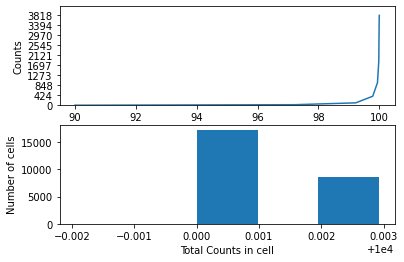

,barcode,group,library_name,marker,max_mt,min_tot,mito_frac,n_counts,n_genes,pool,tissue,treatment
48-pool1,AAACAAACAGAGGATAAGACACCA,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.040964,10000.000977,348,pool1,Liver,NT
98-pool1,AAACAAACAGAGGATACAATACTT,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.005613,10000.000000,581,pool1,Liver,NT
237-pool1,AAACAAACAGAGGATAGGCCCTTA,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.035451,10000.001953,470,pool1,Liver,NT
246-pool1,AAACAAACAGAGGATAGGGAGGTA,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.018000,10000.000000,374,pool1,Liver,NT
342-pool1,AAACAAACAGAGGATATGGCTACC,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.035088,10000.000000,318,pool1,Liver,NT


In [4]:
#sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4, key_n_counts='n_counts', copy=True)

target_sum = 1e4

sc.pp.normalize_total(adata, target_sum=target_sum)
#plt.hist(adata.X.sum(1).A1)
adata_counts = adata.X.todense()
adata_counts = np.array(adata_counts).reshape(-1)

#adata.X.sum(1).A1


fig, axes = plt.subplots(2)

axes[0].plot(100 - np.logspace(1,-4,10), np.percentile(adata_counts, 100 - np.logspace(1,-10,10)))
axes[0].set_xlabel('Counts matrix percentile')
axes[0].set_ylabel('Counts')
axes[0].set_ylim([0, np.max(adata_counts)*1.1])
axes[0].set_yticks(np.linspace(0, np.max(adata_counts), 10))

axes[1].hist(adata.X.sum(1).A1, bins=20)
axes[1].set_xlabel('Total Counts in cell')
axes[1].set_ylabel('Number of cells')


plt.show()

adata.obs['n_counts'] = adata.X.sum(1).A1
adata.obs.head()


In [5]:
#save counts column into a npz df quickly accessible for SPRING

!mkdir -p spring
srz.save_counts_for_spring(adata,'spring/tox_marie_{}'.format(rz.now()), tot_count_column='n_counts')

print(rz.now())

saving for quick loading of genes...
saving for quick loading of cells...
saving as npz...
done
200407_10h50


# Make a SPRING plot using all cells

In [6]:
# out of all cells in adata, select only those you want to plot
# make a copy of the adata object

cell_mask = np.repeat(True,adata.shape[0])
cdata = adata[cell_mask].copy() # all cells in this case

# chose a name for the spring subplot
plot_name = 'all_cells_w_dblt_corr'

# chose dataset for selecting abundant and variable genes
# here I use linear counts-per-10k

E = cdata.X

# in an attempt to be more organized I keep a log of spring parameter and intermediate data structures used in
# the form of an unstructured annotation as part of an AnnData object.

srz.start_spring_params(cdata,plot_name)

# print the newly created dictionary, also define a variable to access it faster:
pdict = cdata.uns['spring_params'][plot_name]
pdict

{'k': 5,
 'cell_mask': array([ True,  True,  True, ...,  True,  True,  True]),
 'min_counts': 3,
 'min_cells': 3,
 'base_ix': array([    0,     1,     2, ..., 35355, 35356, 35357]),
 'num_pc': 20,
 'plot_name': 'all_cells_w_dblt_corr'}

In [7]:
# overwrite some of the parameters for SPRING
pdict['cell_mask'] = cell_mask # record which cell out of all were used
pdict['k'] = 10

pdict['min_counts'] = 10
pdict['min_cells'] = 5

pdict

{'k': 10,
 'cell_mask': array([ True,  True,  True, ...,  True,  True,  True]),
 'min_counts': 10,
 'min_cells': 5,
 'base_ix': array([    0,     1,     2, ..., 35355, 35356, 35357]),
 'num_pc': 20,
 'plot_name': 'all_cells_w_dblt_corr'}

In [8]:
# avoid genes starting with
toavoid = ['mt-','Rps','Rpl','Mrpl','Mrps']
for i in toavoid:
    print(i)
    print([g for g in adata.var_names if g.startswith(i)])
    print()
    print()

mt-
['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']


Rps
['Rps6kc1', 'Rps21', 'Rps4x', 'Rps6ka6', 'Rps6ka3', 'Rps3a1', 'Rps27', 'Rps20', 'Rps6', 'Rps8', 'Rps6ka1', 'Rps9', 'Rps5', 'Rps19', 'Rps16', 'Rps11', 'Rps17', 'Rps3', 'Rps13', 'Rps15a', 'Rps12', 'Rps15', 'Rps26', 'Rps24', 'Rps25', 'Rps27l', 'Rps27rt', 'Rpsa', 'Rps27a', 'Rps6kb1', 'Rps18-ps5', 'Rps23', 'Rps7', 'Rps29', 'Rps6kl1', 'Rps6ka5', 'Rps19bp1', 'Rps6ka2', 'Rps2', 'Rps10', 'Rps28', 'Rps18', 'Rps14', 'Rps6kb2', 'Rps6ka4']


Rpl
['Rpl7', 'Rpl31', 'Rpl37a', 'Rpl7a', 'Rpl12', 'Rpl35', 'Rpl39', 'Rpl10', 'Rpl36a', 'Rpl22l1', 'Rpl34', 'Rpl11', 'Rpl22', 'Rpl9', 'Rpl5', 'Rplp0', 'Rpl6', 'Rpl21', 'Rpl32', 'Rpl28', 'Rpl13a', 'Rpl18', 'Rpl27a', 'Rplp2', 'Rpl41', 'Rpl18a', 'Rpl13', 'Rpl15', 'Rpl36a-ps1', 'Rpl10-ps3', 'Rplp1', 'Rpl4', 'Rpl29', 'Rpl14', 'Rpl26', 'Rpl23a', 'Rpl9-ps1', 'Rpl23', 'Rpl19', 'Rpl27', 'Rpl38', 'Rpl10l', 'Rpl36al', 'Rpl37', 'Rp

In [9]:
# genes to exclude:
exclude_gene_names = []
for j in toavoid:
    exclude_gene_names.append([i for i in adata.var_names if i.startswith(j)])
exclude_gene_names = rz.flatten_list_of_lists(exclude_gene_names)

pdict['gene_names_excluded'] = exclude_gene_names
print('%d genes excluded based on name'%len(exclude_gene_names))


##########################################################################################

# filter on abundance:
pdict['abundant_gene_mask'] = srz.filter_abund_genes(
                                                     E,
                                                     pdict['min_counts'],
                                                     pdict['min_cells']
                                                    )

193 genes excluded based on name
13262 genes passing abundance filter


In [10]:
# combine gene filters so far
undesired = list(pdict['gene_names_excluded'])+\
            list(cdata.var_names[~pdict['abundant_gene_mask']])

print(len(undesired))
undesired = list(set(undesired))
print(len(undesired))

# boolean mask
combmask = ~np.in1d(cdata.var_names,undesired)
print(combmask.sum(),'surviving genes so far')

9562
9557
13074 surviving genes so far


In [11]:
# calculate v score (Klein et al., 2015, see equation S4 and S13) for all non-zero genes
isexpr = np.array(E.sum(axis=0))[0]>0
print('%d genes with non-zero expression'%sum(isexpr))
pdict['v_score_dict'] = srz.vscores(E[:,isexpr])

16280 genes with non-zero expression


In [12]:
# get genes above mode, i.e. any that can be considered variable
gabmod = cdata.var_names[isexpr][pdict['v_score_dict']['var_gene_mask']]
print(len(gabmod),'variable genes')

9708 variable genes


In [13]:
# update combmask:
mvar = np.in1d(cdata.var_names,gabmod)
print(mvar.sum())
combmask = combmask&mvar
print(combmask.sum(),'abundant and variable genes')

9708
8605 abundant and variable genes


In [14]:
# if filtering on correlation, get gene-gene correlation (quite slow)
corx = E[:,combmask]
print(corx.shape)
corx = srz.sparse_corrcoef(corx.T)
corx = np.array(corx)

(35358, 8605)
1.51 min.


In [15]:
# select correlation filters (largely arbitrary), as described in Klein et al. 2015
genes_at_least = 3 #at least this number of genes correlated to any other gene
corr_at_least = 0.15 #with a Pearson correlation coefficient at least this large

################################################################################

# genes passing correlation filter
cormask = (abs(corx)>corr_at_least).sum(axis=0)>genes_at_least #"more than" as one instance is the gene itself with r=1
print((~cormask).sum(), 'genes to exclude based on correlation')

# combine filter
pdict['genes_used'] = cdata.var_names[combmask][cormask]
print(len(pdict['genes_used']),'genes surviving all filters')

6547 genes to exclude based on correlation
2058 genes surviving all filters


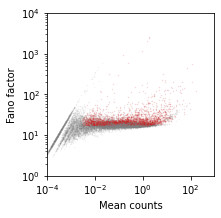

In [16]:
# plot a fano factor vs mean plot with genes used further colored in red
ff = pdict['v_score_dict']['ff_gene']
mu = pdict['v_score_dict']['mu_gene']
finalmask = np.in1d(cdata.var_names,pdict['genes_used'])

# check scatter
s = 2
plt.figure(figsize=(3,3))
plt.scatter(mu,ff,lw=0,color='0.5',alpha=0.1,s=s)
plt.scatter(mu[finalmask[isexpr]],ff[finalmask[isexpr]],lw=0,color='r',alpha=0.1,s=s)
plt.xscale('log');
plt.yscale('log');
plt.xlim(0.0001,1000)
plt.ylim(1,10000)
plt.xlabel('Mean counts')
plt.ylabel('Fano factor');

# Prepare data for PCA

In [17]:
# leave only genes defined as variable, overwrite
print(cdata.shape)
finalmask = np.in1d(cdata.var_names,pdict['genes_used'])
cdata = cdata[:,finalmask]
print(cdata.shape)

(35358, 22631)
(35358, 2058)


In [18]:
# zscore (note:when applying batch correction this step is a bit more involved)
sc.pp.scale(cdata)
Z = cdata.X

/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:912: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [19]:
# find the number of non-random PCs. Shuffling 3 times would be enough here for the initial plot.
d = srz.find_num_pc(Z,start_pc=500,sparse=False,n=5)

calculating the first 500 observed eigenvalues...
calculating the random eigenvalues for 5 rounds of shuffling...
1 	 174 	 2.22 min.
2 	 160 	 3.70 min.
3 	 176 	 5.20 min.
4 	 184 	 6.68 min.
5 	 183 	 8.16 min.


In [20]:
# record results to log:
pdict['num_pc'] = d['num_pc']
pdict['eigenvectors'] = d['pca'].components_
pdict['eigenvalues'] = d['pca'].explained_variance_

print(d['num_pc'])

160


In [21]:
# apply dimensionality reduction on Z (get principle components)
# note, that eigenvalues can be calculated for base_ix only
# make sure to provide a dense matrix Z

P = pdict['eigenvectors'][:pdict['num_pc'],:].dot(Z.T).T
print(P.shape)

(35358, 160)


In [22]:
# Place the principle component data into an AnnData object to use scanpynian functions downstream

P = sc.AnnData(P)

# Klunctions backtrack from 35

### Run PCA on the z-scored data


In [23]:
start = time()
sc.tl.pca(cdata, n_comps=d['num_pc'], svd_solver='arpack')
print(time() - start)

computing PCA with n_comps = 160
    finished (0:01:08)
68.24487495422363


In [24]:
sc.pp.neighbors(cdata, n_neighbors=10, use_rep='X_pca')


computing neighbors


/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../home/

    finished (0:00:56)


In [25]:
sc.tl.umap(cdata)

computing UMAP
    finished (0:00:49)


In [26]:
sc.tl.louvain(cdata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:07)


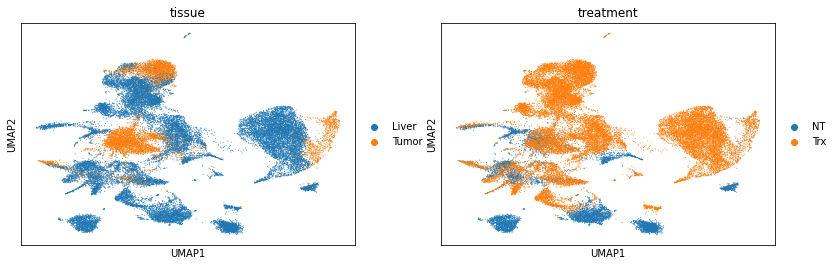

In [27]:
sc.pl.umap(cdata, color=['tissue','treatment'])
#plt.gcf()#.patch.set_facecolor('white')


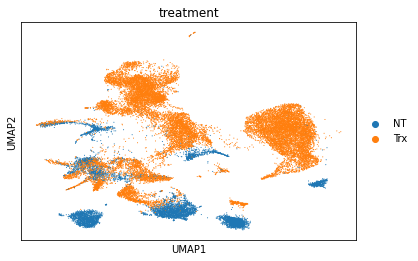

In [28]:
sc.pl.umap(cdata[cdata.obs['tissue']=='Liver'], color=['treatment'])

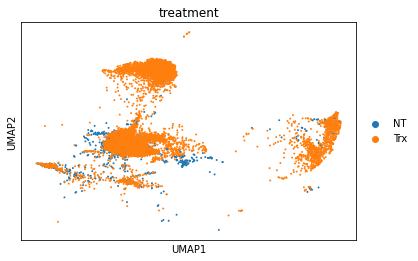

In [29]:
sc.pl.umap(cdata[cdata.obs['tissue']=='Tumor'], color=['treatment'])

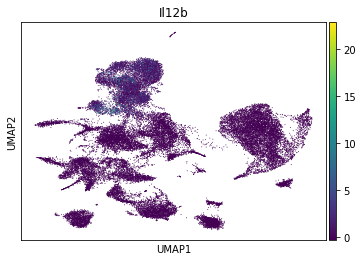

In [30]:
sc.pl.umap(cdata, color=['Il12b'])

# Save SPRING plot

In [31]:
!mkdir -p spring

embedding_use = 'umap'
spring_dir = 'spring/'

spring_data = cdata
spring_data.X = sp.sparse.csr.csr_matrix(spring_data.X)

sc.external.exporting.spring_project(spring_data, # adata object
                            '{}/tox_marie'.format(spring_dir), # main SPRING directory for this dataset
                            embedding_use, # 2-D embedding to use for output
                            subplot_name='all_cells_{}'.format(rz.now()), # SPRING subplot directory for this particular embedding/parameter set
                           )

Writing subplot to spring/tox_marie/all_cells_200407_11h03


# Save part 2A results in backup folder, including dimensions and time stamp

In [33]:
!mkdir -p backups

start = time()
cdata.write('backups/tox_marie_all_cells_umap{}x{}_backup_{}.h5ad'.format(*adata.shape,rz.now()))

print(time()-start)

start = time()
rz.save_df(cdata.obs, 'backups/tox_marie_all_cells_umap_meta_{}x{}_{}'.format(*adata.obs.shape, rz.now()))
print(time()-start)



0.36365747451782227


/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/format.py:356: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


In [ ]:
npz = np.load('backups/log')
df= pd.DataFrame.from_dict({item: npz[item] for item in npz.files}, orient='index')


In [1]:
2

2